In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import json
import pandas as pd

import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.time_measurement as time_measurement
from lib.ext.baycon.common.DataAnalyzer import *
from lib.ext.baycon.common.Target import Target
from lib.ext.baycon.common.ScoreCalculator import ScoreCalculator
from lib.score_calculator_kmeans import ScoreCalculatorKmeans

<Axes: >

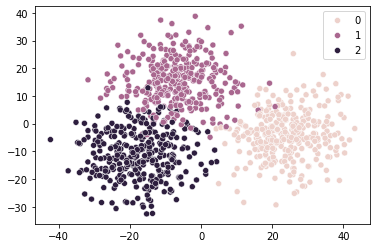

In [2]:
X, y = make_blobs(centers=3, cluster_std=8, n_features=20, n_samples=1000)

pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

In [3]:
model = RandomForestClassifier()
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,label
0,9.228440,6.039117,5.469560,7.982254,-3.098198,2.417716,-0.695038,6.602007,0.281217,7.762304,...,21.198752,-2.411537,-2.007967,7.024122,-4.632799,8.521960,-2.854968,-7.649467,-21.152113,1.0
1,-4.324526,1.980450,-11.004547,9.540642,-2.523541,-0.882074,22.788398,22.705325,6.118603,14.970619,...,10.188090,-3.315511,16.907192,-8.990881,-8.391614,-5.069613,12.473421,12.393354,-7.871745,2.0
2,-12.361759,3.769515,20.689458,7.148627,-7.285701,-5.730283,2.203698,0.964962,15.775310,10.418416,...,1.779600,0.346953,1.314518,-20.635670,-4.864541,-8.760671,-8.909239,2.521111,-1.072862,1.0
3,-14.791384,4.363010,5.168790,-5.138431,4.062698,6.823669,-3.668465,-1.803255,-4.906325,0.613667,...,8.490829,9.270089,-7.268616,-7.588742,12.207822,7.263952,-0.249491,2.713743,-16.569222,1.0
4,9.021852,-8.368285,0.514134,9.341689,3.177188,3.713063,6.610342,2.370437,2.610944,-13.932011,...,-1.355885,-5.031578,-14.627378,7.096726,-5.165699,-2.299342,0.071464,7.597776,2.456208,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.690380,-3.514388,4.881390,9.013018,-9.769077,27.630438,4.650375,6.375494,1.070386,17.132834,...,-8.277334,-2.822228,0.394843,-11.855188,-8.321576,2.291922,30.399262,13.297112,-8.090142,2.0
996,-5.127707,-0.497285,-1.320223,21.201713,-13.806635,7.244326,-3.823484,-4.043266,9.990908,6.244206,...,-0.972824,-1.203371,7.378459,-10.338251,2.422836,-0.074589,-8.833676,-3.459147,-7.801202,1.0
997,-11.579232,-10.225413,11.873774,7.098868,-8.023342,6.300740,-2.457242,-6.530952,9.421195,8.386778,...,-8.338519,14.513822,20.298698,-2.568639,-3.699649,-22.012371,16.871983,10.675567,-14.154300,2.0
998,-19.481098,5.196651,16.441173,15.601142,-6.989134,-8.335932,-8.086329,2.117852,0.725643,0.129943,...,2.903276,5.351122,-9.479914,-18.156039,-1.423217,5.598372,2.603990,-11.644279,-7.885745,1.0


<Axes: >

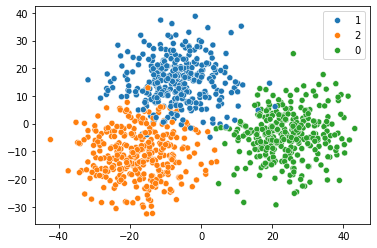

In [4]:
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=pred)

In [5]:
def execute(df, model, target, initial_instance_index, categorical_features=[], actionable_features=[]):
    y = df[[target.target_feature()]].values.ravel()
    X = df.drop([target.target_feature()], axis=1).values
    feature_names = df.columns[df.columns != target.target_feature()]

    run = 0
    data_analyzer = DataAnalyzer(X, y, feature_names, target, categorical_features, actionable_features)
    X, y = data_analyzer.data()
    initial_instance = X[initial_instance_index]
    initial_prediction = y[initial_instance_index]
    print("--- Executing... Initial Instance: {} Target: {} Run: {} ---".format(
        initial_instance_index,
        target.target_value_as_string(),
        run
    ))

    # Initialize ScoreCalculator Classification / Clustering
    initial_instance_f = initial_instance.astype(float)   # np operations need same type object to compute!
    if target.target_type() == Target.TYPE_CLASSIFICATION or target.target_type() == Target.TYPE_REGRESSION:
        score_calculator = ScoreCalculator(initial_instance, initial_prediction, target, data_analyzer)
    elif target.target_type() == Target.TYPE_CLUSTERING_KMEANS:
        base_calculator = ScoreCalculator(initial_instance, initial_prediction, target, data_analyzer)
        cluster_centers = 0 # need centers
        score_calculator = ScoreCalculatorKmeans(initial_instance, initial_prediction, target, data_analyzer, base_calculator, cluster_centers)

    counterfactuals, _ranker = baycon.run(initial_instance_f, initial_prediction, target, data_analyzer, model, score_calculator)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    # output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
    #                                                   target.target_value_as_string(), model_name, run)
    # with open(output_filename, 'w') as outfile:
    #     json.dump(output, outfile)
    # print("--- Finished: saved file {}\n".format(output_filename))

    return counterfactuals, predictions, initial_instance, initial_prediction #, data_analyzer, ranker, model


In [6]:
point_idx = 0
point_pred = int(model.predict([X[point_idx]])[0])
print("Point prediction: ", point_pred, type(point_pred))
t = Target(target_type="classification", target_feature="label", target_value=0)

cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, point_idx)

Point prediction:  1 <class 'int'>
--- Executing... Initial Instance: 0 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (666) CFs (0)
Re-training surrogate model with data size: 666
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (2) Unique overall (2)
Generated random instances: (3235)
Predicted top: 20 Counterfactuals: 4
Found new best [  9.22843992   6.03911667  -2.08599166   7.98225429  -3.09819843
   2.41771609  -0.69503817   3.82709861   0.28121742   7.76230403
 -17.02388487   1.93240207  -2.41153654  -2.00796664   7.02412218
 -12.4853303    8.52196026   3.76963897  -7.64946679   6.10634243], with fitness score 0.6172 (X 0.88177 Y 1.0 F 0.7), oversampling
Known alternatives: 686
Best instance score 0.6172 (X 0.88177 Y 1.0 F 0.7), found on epoch: 1
Re-training surrogate model with data size: 696
--- epoch 2 ----
Generating

<Axes: >

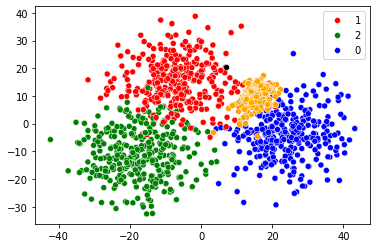

In [7]:
embed_cf = pca.transform(cf)
sns.scatterplot(x=embed_X[:,0], y=embed_X[:,1], hue=pred, palette=['red','green','blue'])
sns.scatterplot(x=embed_cf[:,0], y=embed_cf[:,1], color='orange')
sns.scatterplot(x=embed_X[[0],0], y=embed_X[[0],1], color='black')